Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
mean_weight = mean(df2[:weight]);
df2[:weight_c] = df2[:weight] .- mean_weight;
first(df2, 5)

,height,weight,age,male,weight_c
,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Float64
1,151.765,47.8256,63.0,1,2.83512
2,139.7,36.4858,63.0,0,-8.50468
3,136.525,31.8648,65.0,0,-13.1256
4,156.845,53.0419,41.0,1,8.05143
5,145.415,41.2769,51.0,0,-3.71361


Define the Stan language model

In [5]:
weightsmodel = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] height; // Predictor
 vector[N] weight; // Outcome
}

parameters {
 real alpha; // Intercept
 real beta; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
 height ~ normal(alpha + weight * beta , sigma);
}

generated quantities {
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [6]:
stanmodel = Stanmodel(name="weights", monitors = ["alpha", "beta", "sigma"],model=weightsmodel,
  output_format=:mcmcchain);
# Input data for cmdstan
heightsdata = Dict("N" => length(df2[:height]), "height" => df2[:height], "weight" => df2[:weight_c]);

=====> /Users/rob/.julia/dev/StatisticalRethinking/scripts/04


File /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan will be updated.



Sample using cmdstan

In [7]:
rc, chn, cnames = stan(stanmodel, heightsdata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)



--- Translating Stan model to C++ code ---
bin/stanc  --o=/Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.hpp /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan
Model name=weights_model
Input file=/Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.stan
Output file=/Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.hpp
clang++ -std=c++1y -Wno-unknown-warning-option -Wno-tautological-compare -Wno-sign-compare      -O3 -I src -I stan/src -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.3 -I stan/lib/stan_math/lib/boost_1.66.0 -I stan/lib/stan_math/lib/sundials_3.1.0/include    -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION     -c -MT /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights.o -MT /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights -include /Users/rob/.julia/dev/StatisticalRethinking/scripts/04/tmp/weights

Plot the density of posterior draws

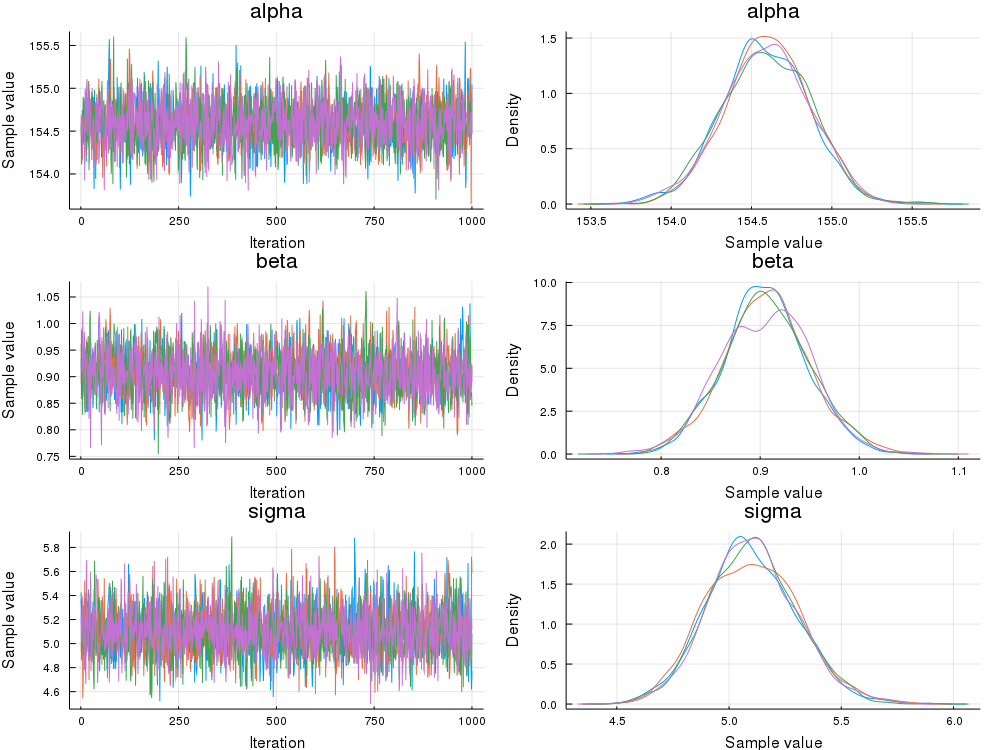

In [8]:
plot(chn)

Plot regression line using means and observations

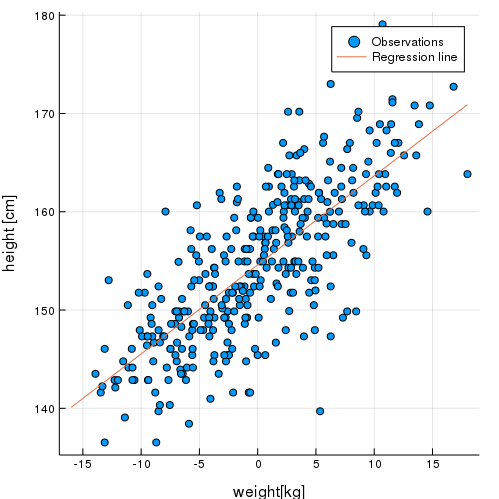

In [9]:
scatter(df2[:weight_c], df2[:height], lab="Observations",
  ylab="height [cm]", xlab="weight[kg]")
xi = -16.0:0.1:18.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)));
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)));
yi = mean(alpha_vals) .+ mean(beta_vals)*xi;
plot!(xi, yi, lab="Regression line")

End of `clip-43s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*